In [298]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [299]:
dataset = pd.read_csv("playground-series-s4e2/train.csv")
org_dataset = pd.read_csv("obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")

# Concatenate the two DataFrames along their rows
dataset = pd.concat([dataset, org_dataset], ignore_index=True)
dataset.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [300]:
# Dropping columns based on low std as compare to mean
columns_to_drop = ['id', 'FAF', 'TUE']
dataset = dataset.drop(columns=columns_to_drop)
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,Sometimes,Public_Transportation,Overweight_Level_II


In [301]:
# Example of creating a new feature: BMI
#dataset['BMI'] = dataset['Weight'] / (dataset['Height'] ** 2)

# Example of interaction term: Age * Weight
dataset['Age_Weight_Interaction'] = dataset['Age'] * dataset['Weight']

In [302]:
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,CALC,MTRANS,NObeyesdad,Age_Weight_Interaction
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,Sometimes,Public_Transportation,Overweight_Level_II,1996.259486
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,no,Automobile,Normal_Weight,1026.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,no,Public_Transportation,Insufficient_Weight,902.983572
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,Sometimes,Public_Transportation,Obesity_Type_III,2750.567428
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,Sometimes,Public_Transportation,Overweight_Level_II,2967.871856


In [303]:
# Use LabelEncoder for binary columns
binary_columns = ['Gender','family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'NObeyesdad']
label_encoder = LabelEncoder()
for col in binary_columns:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [304]:
# One-hot encode categorical columns
categorical_columns = ['CAEC', 'CALC', 'MTRANS']
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(dataset[col], prefix=col)
    dataset = pd.concat([dataset, one_hot_encoded], axis=1)
    dataset.drop(columns=[col], inplace=True)

In [305]:
bool_columns = dataset.select_dtypes(include=['bool']).columns
dataset[bool_columns] = dataset[bool_columns].astype(int)
print(dataset.dtypes)


Gender                              int32
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int32
FAVC                                int32
FCVC                              float64
NCP                               float64
SMOKE                               int32
CH2O                              float64
SCC                                 int32
NObeyesdad                          int32
Age_Weight_Interaction            float64
CAEC_Always                         int32
CAEC_Frequently                     int32
CAEC_Sometimes                      int32
CAEC_no                             int32
CALC_Always                         int32
CALC_Frequently                     int32
CALC_Sometimes                      int32
CALC_no                             int32
MTRANS_Automobile                   int32
MTRANS_Bike                         int32
MTRANS_Motorbike                  

In [306]:
# Split data into features and target
X = dataset.drop(columns=['NObeyesdad'])
y = dataset['NObeyesdad']


In [307]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
# Apply standard scaling to numerical features after splitting
scaler = StandardScaler()
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O','Age_Weight_Interaction']
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [309]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

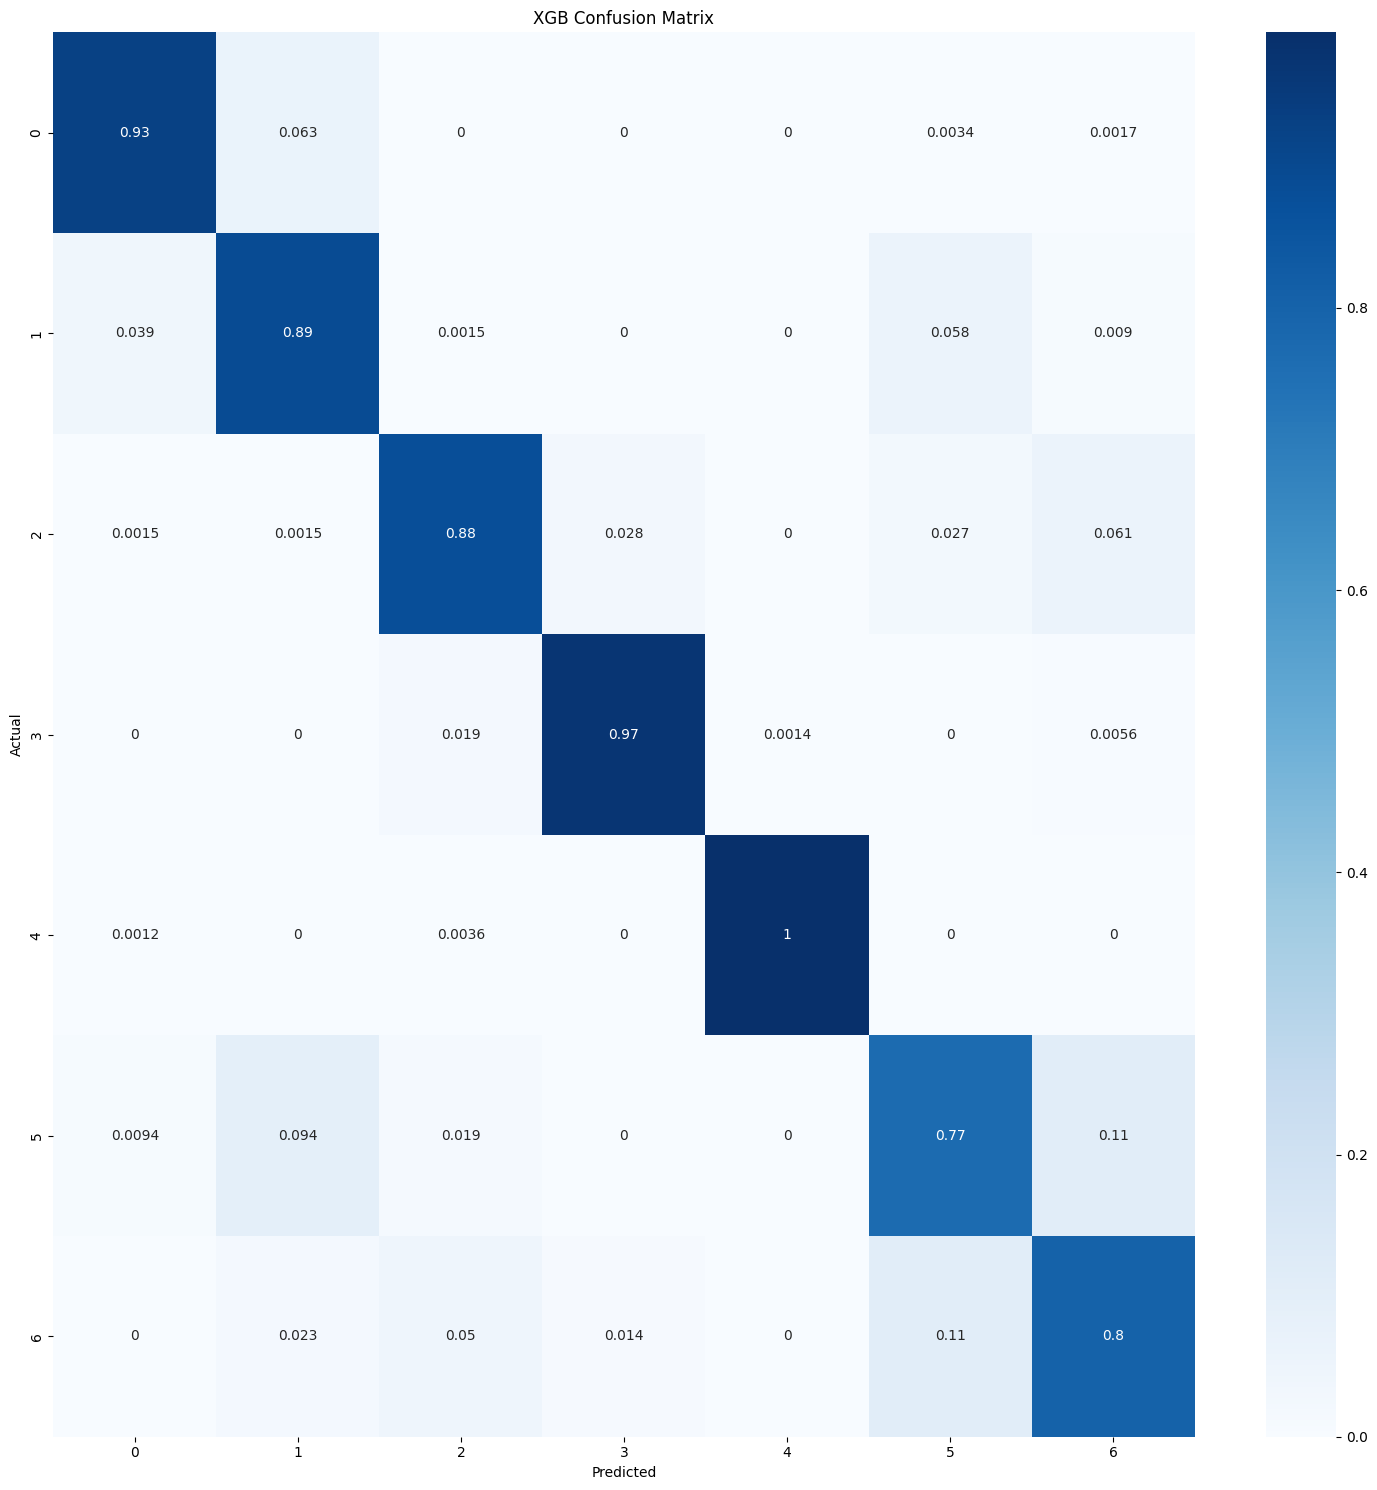

XGB accuracy_score: 0.9020550940096196


In [310]:

xg = xgb.XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=3)

xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

plot_confusion_matrix(y_test, y_pred_xg, 'XGB Confusion Matrix')
print("XGB accuracy_score:", accuracy_score(y_test, y_pred_xg))